# Example 1 - The farmer's problem

Recall the farmers problems, who is trying to determine what is the best land allocation for her crops given the uncertainty in the production yield.


In [61]:
# Loading the packages we need
using JuMP 
using HiGHS
using Plots

The deterministic data for the problem is as below:

In [62]:
max_area = 500.0;
crops = [:wheat, :corn, :sugar_beet];
plant_cost = Dict(
    :wheat      => 150.0,
    :corn       => 230.0,
    :sugar_beet => 260.0
);
min_qt = Dict(
    :wheat      => 200.0,
    :corn       => 240.0,
    :sugar_beet => 0.0
);

quota_max = Dict(
    :wheat      => 200000, # This is large enough to not limit production
    :corn       => 200000, 
    :sugar_beet => 6000.0
);

sell_quota = Dict(
    :wheat      => 170.0,
    :corn       => 150.0,
    :sugar_beet => 36.0
);

sell_above = Dict(
    :wheat      => 0.0,
    :corn       => 0.0,
    :sugar_beet => 10.0
);

buy_price = Dict(
    :wheat      => 238.0,
    :corn       => 210.0,
    :sugar_beet => 1000.0
);

mean_yield = Dict(
    :wheat      => 2.5,
    :corn       => 3.0,
    :sugar_beet => 20.0
);

The deterministic model has the following formulation:

Let $I=\{1:\text{wheat}, 2:\text{corn}, 3:\text{sugar beets}\}$. Then
- $x_i$	- acres devoted to $i$
- $y_i$ - tons of $i$ purchased, $i \in I \setminus \{3\}$
- $w_i$ - tons of $i$ sold, $i \in I \cup \{4\}$, $\{4: \text{sugar beets (over quota)}\}$.
	
The farmer's problem is:

\begin{align*}
    \min\; & 150x_1 + 230 x_2 + 260 x_3 + 238 y_1 + 210 y_2 \\ & - 170 w_1 - 150 w_2 - 36 w_3 - 10w_4 \\
    \text{s.t.: } & x_1 + x_2 + x_3 \le 500 \quad && \text{(acres planted)}\\
    & 2.5x_1 + y_1 - w_1 \ge 200 && \text{(wheat to feed)}\\
    & 3 x_2 + y_2 - w_2 \ge 240 && \text{(corn to feed)}\\
    & w_3 + w_4 \le 20x_3 && \text{(amount of sugar beets)}\\
    & w_3 \le 6000 && \text{(sugar beet quota)}\\
    & x_i \ge 0, i \in I; y_i \ge 0, i \in I \setminus \{3\}; w_i \ge 0, i \in I \cup \{4\}.
\end{align*}


In [63]:
fm_mean = Model(HiGHS.Optimizer)

@variable(fm_mean, x[c ∈ crops] ≥ 0)     # Planted area per crop
@variable(fm_mean, w[c ∈ crops] ≥ 0)     # Quantity sold below the quota
@variable(fm_mean, z[c ∈ crops] ≥ 0)     # Quantity sold above the quota (restricted by the max quota)
@variable(fm_mean, y[c ∈ crops] ≥ 0)     # Quantity bought

@constraint(fm_mean, sum(x[c] for c ∈ crops) ≤ max_area)   
@constraint(fm_mean, [c ∈ crops], x[c] * mean_yield[c] + y[c] - w[c] - z[c] ≥  min_qt[c])                                                            
@constraint(fm_mean, [c ∈ crops], w[c] ≤ quota_max[c])    

@expression(fm_mean, cost_det, sum(plant_cost[c] * x[c] for c ∈ crops))
@expression(fm_mean, cost_sto, sum((buy_price[c] * y[c] - sell_quota[c]*w[c] - sell_above[c] * z[c]) for c ∈ crops))       

@objective(fm_mean, Min, cost_det + cost_sto);

We can check the model to see if we got it right.

In [64]:
# Checking the model
print(fm_mean)

Min 150 x[wheat] + 230 x[corn] + 260 x[sugar_beet] + 238 y[wheat] - 170 w[wheat] + 210 y[corn] - 150 w[corn] + 1000 y[sugar_beet] - 36 w[sugar_beet] - 10 z[sugar_beet]
Subject to
 2.5 x[wheat] - w[wheat] - z[wheat] + y[wheat] ≥ 200
 3 x[corn] - w[corn] - z[corn] + y[corn] ≥ 240
 20 x[sugar_beet] - w[sugar_beet] - z[sugar_beet] + y[sugar_beet] ≥ 0
 x[wheat] + x[corn] + x[sugar_beet] ≤ 500
 w[wheat] ≤ 200000
 w[corn] ≤ 200000
 w[sugar_beet] ≤ 6000
 x[wheat] ≥ 0
 x[corn] ≥ 0
 x[sugar_beet] ≥ 0
 w[wheat] ≥ 0
 w[corn] ≥ 0
 w[sugar_beet] ≥ 0
 z[wheat] ≥ 0
 z[corn] ≥ 0
 z[sugar_beet] ≥ 0
 y[wheat] ≥ 0
 y[corn] ≥ 0
 y[sugar_beet] ≥ 0


We can then optimise the model

In [65]:
optimize!(fm_mean);

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 2e+01]
  Cost   [1e+01, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [2e+02, 2e+05]
Presolving model
4 rows, 10 cols, 13 nonzeros  0s
4 rows, 10 cols, 13 nonzeros  0s
Presolve : Reductions: rows 4(-3); columns 10(-2); elements 13(-5)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.9999685495e+01 Ph1: 1(1); Du: 1(39.9997) 0s
          5    -1.1860000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 5
Objective value     : -1.1860000000e+05
HiGHS run time      :          0.00


In [66]:
# Extract values from model
sol_plant_mean = round.(value.(x),digits=2)                 # Areas planted
sol_bought_mean = round.(value.(y),digits=2)                # Quantities bought
sol_sold_bq_mean = round.(value.(w),digits=2)               # Sold below quota
sol_sold_aq_mean = round.(value.(z),digits=2)               # Sold above quota
obj_mean = objective_value(fm_mean)

# Print values
println("crops = ", crops)
println("sol_plant_mean = ",[sol_plant_mean[c] for c in crops])
println("sol_bought_mean = ",[sol_bought_mean[c] for c in crops])
println("sol_sold_bq_mean = ",[sol_sold_bq_mean[c] for c in crops])
println("sol_sold_aq_mean = ",[sol_sold_aq_mean[c] for c in crops])
println("obj = ", obj_mean)

crops = [:wheat, :corn, :sugar_beet]
sol_plant_mean = [120.0, 80.0, 300.0]
sol_bought_mean = [0.0, 0.0, 0.0]
sol_sold_bq_mean = [100.0, 0.0, 6000.0]
sol_sold_aq_mean = [0.0, 0.0, 0.0]
obj = -118600.0


Let us now generate the scenarios for the yields. We assume that all scenarios have the same probability 1/3 with `:good` being +20% above and `:bad` being 20% below the `:mean` scenario.  

In [67]:
scenarios = [:good, :mean, :bad];
yield_sto = Dict(
    :good => 1.2,
    :mean => 1,
    :bad  => 0.8
)

prob = Dict(
    :good => 1/3,
    :mean => 1/3,
    :bad  => 1/3
);

We can adapt the formulation accordingly. Notice the new set/ indices refering to the scenarios. Also, the variables are now indexed by `s in scenario` accordingly.

In [68]:
fm = Model(HiGHS.Optimizer)

# First stage
@variable(fm, x[c ∈ crops] ≥ 0)                                              
@constraint(fm, sum(x[c] for c ∈ crops) ≤ max_area)                           
@expression(fm, first_cost, sum(plant_cost[c] * x[c] for c ∈ crops))             

# Second stage
@variable(fm, w[c ∈ crops, s ∈ scenarios] ≥ 0)                                
@variable(fm, z[c ∈ crops, s ∈ scenarios] ≥ 0)                                
@variable(fm, y[c ∈ crops, s ∈ scenarios] ≥ 0)                               

@constraint(fm, [c ∈ crops, s ∈ scenarios],                                   
    x[c] * (mean_yield[c] * yield_sto[s]) + y[c,s] - w[c,s] - z[c,s] ≥ min_qt[c]
) 

@constraint(fm, [c ∈ crops,s ∈ scenarios], w[c,s] ≤ quota_max[c])                                                   

@expression(fm, second_cost[s ∈ scenarios],
            sum(buy_price[c] * y[c,s] - sell_quota[c] * w[c,s] - sell_above[c] * z[c,s] 
                for c ∈ crops)
)

@objective(fm, Min, first_cost + sum(prob[s] * second_cost[s] for s ∈ scenarios));

In [69]:
# Checking the model
print(1,fm)

1Min 150 x[wheat] + 230 x[corn] + 260 x[sugar_beet] + 79.33333333333333 y[wheat,good] - 56.666666666666664 w[wheat,good] + 70 y[corn,good] - 50 w[corn,good] + 333.3333333333333 y[sugar_beet,good] - 12 w[sugar_beet,good] - 3.333333333333333 z[sugar_beet,good] + 79.33333333333333 y[wheat,mean] - 56.666666666666664 w[wheat,mean] + 70 y[corn,mean] - 50 w[corn,mean] + 333.3333333333333 y[sugar_beet,mean] - 12 w[sugar_beet,mean] - 3.333333333333333 z[sugar_beet,mean] + 79.33333333333333 y[wheat,bad] - 56.666666666666664 w[wheat,bad] + 70 y[corn,bad] - 50 w[corn,bad] + 333.3333333333333 y[sugar_beet,bad] - 12 w[sugar_beet,bad] - 3.333333333333333 z[sugar_beet,bad]
Subject to
 3 x[wheat] - w[wheat,good] - z[wheat,good] + y[wheat,good] ≥ 200
 3.5999999999999996 x[corn] - w[corn,good] - z[corn,good] + y[corn,good] ≥ 240
 24 x[sugar_beet] - w[sugar_beet,good] - z[sugar_beet,good] + y[sugar_beet,good] ≥ 0
 2.5 x[wheat] - w[wheat,mean] - z[wheat,mean] + y[wheat,mean] ≥ 200
 3 x[corn] - w[corn,mean]

In [70]:
optimize!(fm);

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 2e+01]
  Cost   [3e+00, 3e+02]
  Bound  [0e+00, 0e+00]
  RHS    [2e+02, 2e+05]
Presolving model
10 rows, 24 cols, 33 nonzeros  0s
10 rows, 24 cols, 33 nonzeros  0s
Presolve : Reductions: rows 10(-9); columns 24(-6); elements 33(-15)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.9999795838e+01 Ph1: 3(3); Du: 3(39.9998) 0s
         15    -1.0839000000e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 15
Objective value     : -1.0839000000e+05
HiGHS run time      :          0.00


In [71]:
# Extract values from model
sol_plant = round.(value.(x),digits=2)          # Areas planted
sol_bought = round.(value.(y),digits=2)         # Quantities bought
sol_sold_bq = round.(value.(w),digits=2)        # Sold below quota
sol_sold_aq = round.(value.(z),digits=2);       # Sold above quota
obj = objective_value(fm)

# Print solution
println("sol_plant = ", [sol_plant[c] for c in crops])
println("obj = ", obj)
for s in scenarios
    println("scenario: ", s)
    println("   crops = ", crops)
    println("   sol_bought = ", [sol_bought[c,s] for c in crops])
    println("   sol_sold_bq = ", [sol_sold_bq[c,s] for c in crops])
    println("   sol_sold_aq = ",[sol_sold_aq[c,s] for c in crops])
end

sol_plant = [170.0, 80.0, 250.0]
obj = -108390.0
scenario: good
   crops = [:wheat, :corn, :sugar_beet]
   sol_bought = [0.0, 0.0, 0.0]
   sol_sold_bq = [310.0, 48.0, 6000.0]
   sol_sold_aq = [0.0, 0.0, 0.0]
scenario: mean
   crops = [:wheat, :corn, :sugar_beet]
   sol_bought = [0.0, 0.0, 0.0]
   sol_sold_bq = [225.0, 0.0, 5000.0]
   sol_sold_aq = [0.0, 0.0, 0.0]
scenario: bad
   crops = [:wheat, :corn, :sugar_beet]
   sol_bought = [0.0, 48.0, 0.0]
   sol_sold_bq = [140.0, 0.0, 4000.0]
   sol_sold_aq = [0.0, 0.0, 0.0]


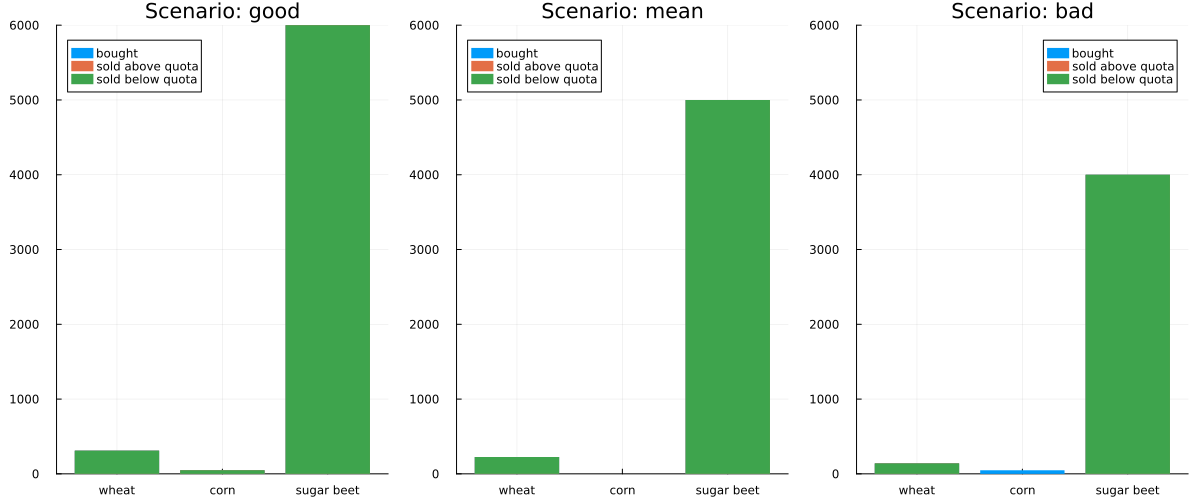

In [72]:
# Plot results
crops_s = ["wheat", "corn", "sugar beet"]
plots = []
for s in scenarios
    p_temp = bar(crops_s, [sol_bought[c,s]+sol_sold_bq[c,s]+sol_sold_aq[c,s] for c in crops], label="bought", title="Scenario: $(s)")
             bar!(crops_s, [sol_sold_bq[c,s]+sol_sold_aq[c,s] for c in crops], stacked=true, label="sold above quota")
             bar!(crops_s, [sol_sold_bq[c,s] for c in crops], stacked=true, label="sold below quota")
    push!(plots, p_temp)
end
plot(plots...,layout = (1,3), size=(1200,500), link=:y,linecolor=false)

## Value of stochastic solution

To calculate the value of stochastic solution, we need to compare the 
1. performance between the solution we obtain considering only one scenario (`:mean` scenario in our case), 
$z^{\text{EV}} = \mathbb{E}_\xi\left[F(x(\overline{\xi}), \xi)\right],$ where $x(\overline{\xi}) = \argmin_x F(x, \overline{\xi})$ and $\overline{\xi}$ is the `:mean` scenario;
2. and that of the stochastic model.

For (1), we can simply add a constraint to the stochastic model that forces the first-stage solution to be the same of model with the average scenario only.

Coefficient ranges:
  Matrix [1e+00, 2e+01]
  Cost   [3e+00, 3e+02]
  Bound  [0e+00, 0e+00]
  RHS    [8e+01, 2e+05]
Solving LP without presolve, or with basis, or unconstrained
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0838849981e+05 Pr: 2(400) 0s
          1    -1.0724000000e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1
Objective value     : -1.0724000000e+05
HiGHS run time      :          0.00
---------
2SSP objective value = -108390.0
EV value = -107239.99999999999
VSS = -1150.0000000000146


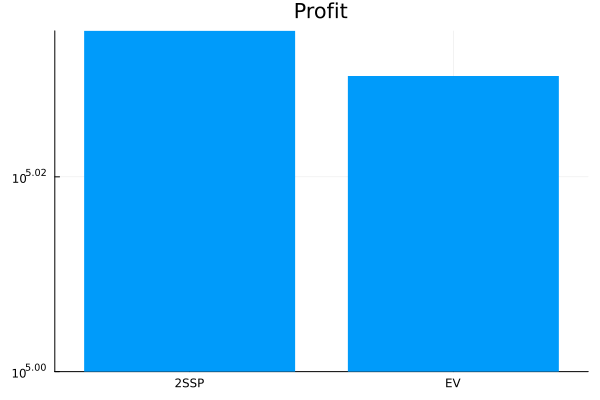

In [73]:
# Form the EV problem
@constraint(fm, [c in crops], x[c] == sol_plant_mean[c]);  
optimize!(fm);
println("---------")
EEV = objective_value(fm)
println("2SSP objective value = ", obj)
println("EV value = ", objective_value(fm))
println("VSS = ", obj - objective_value(fm))
# Plot
bar(["2SSP", "EV"],[-obj; -objective_value(fm)], label=false, yscale=:log10, title="Profit",linecolor=false)

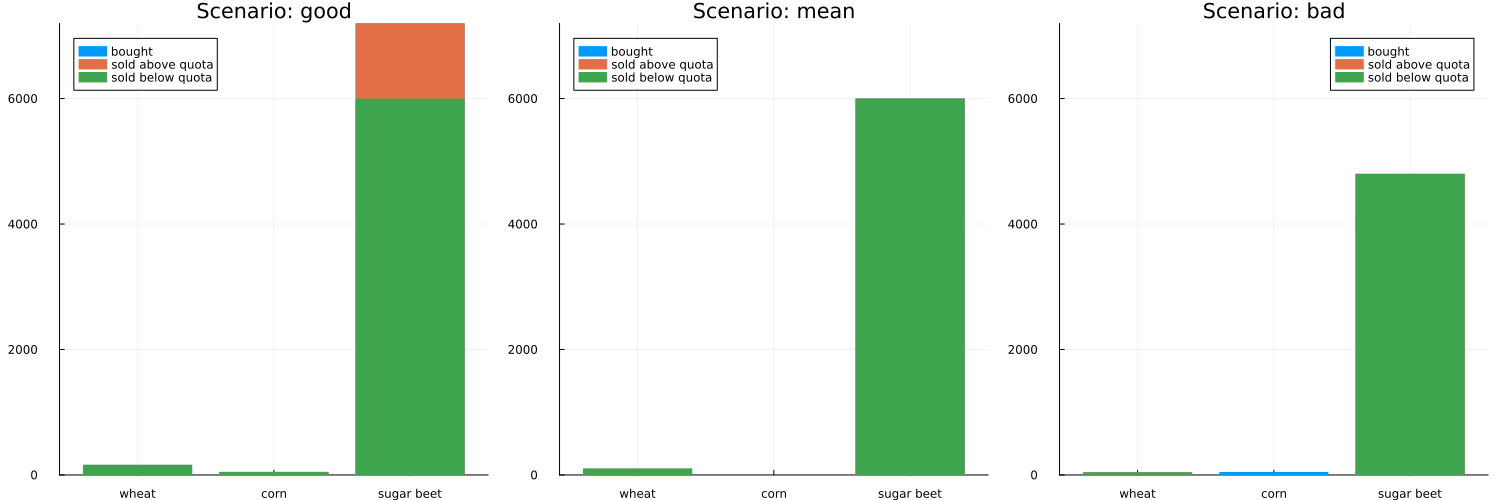

In [74]:
# Plot results
plots = []
for s in scenarios
    p_temp = bar(crops_s, [value.(y)[c,s]+value.(w)[c,s]+value.(z)[c,s] for c in crops], label="bought", title="Scenario: $(s)")
             bar!(crops_s, [value.(w)[c,s]+value.(z)[c,s] for c in crops], stacked=true, label="sold above quota")
             bar!(crops_s, [value.(w)[c,s] for c in crops], stacked=true, label="sold below quota")
    push!(plots, p_temp)
end
plot(plots...,layout = (1,3), size=(1500,500), link=:y,linecolor=false)

## Expected Value of Perfect Information

To calculate the EVPI, we need to calculate the fully anticipative solution, meaning that we need to calculate
\begin{equation*}
    z^{\text{WS}} = \mathbb{E}_\xi\left[ \min_x \{F(x,\xi)\} \right] = \mathbb{E}_\xi\left[F(x(\xi), \xi)\right],
\end{equation*}

This consists of calculating the optimal solution for each scenario, and then take the expected value.

Firest, let us solve again our stochastic model to refresh it to its original form:

In [75]:
# Restart the 2SSP model (C&P from above)
fm = Model(HiGHS.Optimizer)
set_silent(fm)
@variable(fm, x[c ∈ crops] ≥ 0)                                              
@constraint(fm, sum(x[c] for c ∈ crops) ≤ max_area)                           
@expression(fm, first_cost, sum(plant_cost[c] * x[c] for c ∈ crops))             

@variable(fm, w[c ∈ crops, s ∈ scenarios] ≥ 0)                                
@variable(fm, z[c ∈ crops, s ∈ scenarios] ≥ 0)                                
@variable(fm, y[c ∈ crops, s ∈ scenarios] ≥ 0)                               

@constraint(fm, [c ∈ crops, s ∈ scenarios],                                   
    x[c] * (mean_yield[c] * yield_sto[s]) + y[c,s] - w[c,s] - z[c,s] ≥ min_qt[c]
)                                                                
@constraint(fm, [c ∈ crops,s ∈ scenarios], w[c,s] ≤ quota_max[c])                                                   

@expression(fm, second_cost[s ∈ scenarios],
            sum(buy_price[c] * y[c,s] - sell_quota[c] * w[c,s] - sell_above[c] * z[c,s] 
                for c ∈ crops)
)

@objective(fm, Min, first_cost + sum(prob[s] * second_cost[s] for s ∈ scenarios));

In [76]:
optimize!(fm);
obj = objective_value(fm)

-108390.0

Our trick to calculate the WS solution is to use an auxiliary probability vector `aux_prob` that we can "mess with". 

That means, we first zero the dictionary containing the probability and then, for each scenario, we set that scenario to have probability 1. We then accumulate the value in the `WS` auxiliary variable, multiplied by the original probability.

In [77]:
# Calculating WS
plots = []
aux_prob = copy(prob)
WS = 0.0

# Initially, set all probabilities to 0
for (key, val) in aux_prob
    aux_prob[key] = 0
end

# For every scenario
for (key, val) in prob
    # Set corresponding probability to 1
    aux_prob[key] = 1
    # Update objective
    @objective(fm, Min, first_cost + sum(aux_prob[s] * second_cost[s] for s in scenarios))
    optimize!(fm)
    WS += prob[key] * objective_value(fm) 
    aux_prob[key] = 0
    
    # Collect plot data
    p_temp = bar(crops_s, [value(y[c,key])+value(w[c,key])+value(z[c,key]) for c in crops], label="bought", title="Scenario: $(key)")
             bar!(crops_s, [value(w[c,key])+value(z[c,key]) for c in crops], stacked=true, label="sold above quota")
             bar!(crops_s, [value(w[c,key]) for c in crops], stacked=true, label="sold below quota")
    push!(plots, p_temp)     
end

println("The WS value is: ", WS)
println("EVPI is: ", WS - obj)

The WS value is: -115405.55555555555
EVPI is: -7015.5555555555475


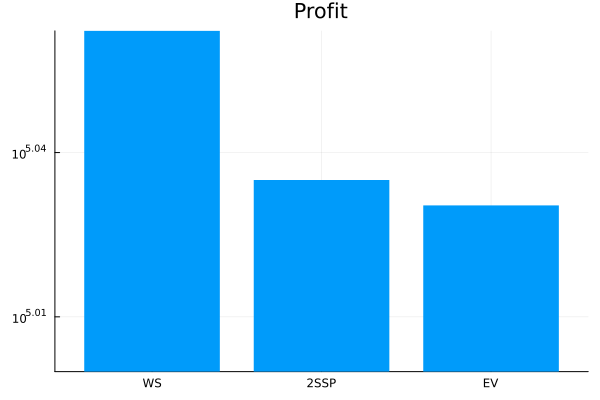

In [78]:
# Plot objectives
bar(["WS", "2SSP", "EV"],[-WS; -obj; -EEV], label=false, yscale=:log10, title="Profit",linecolor=false)

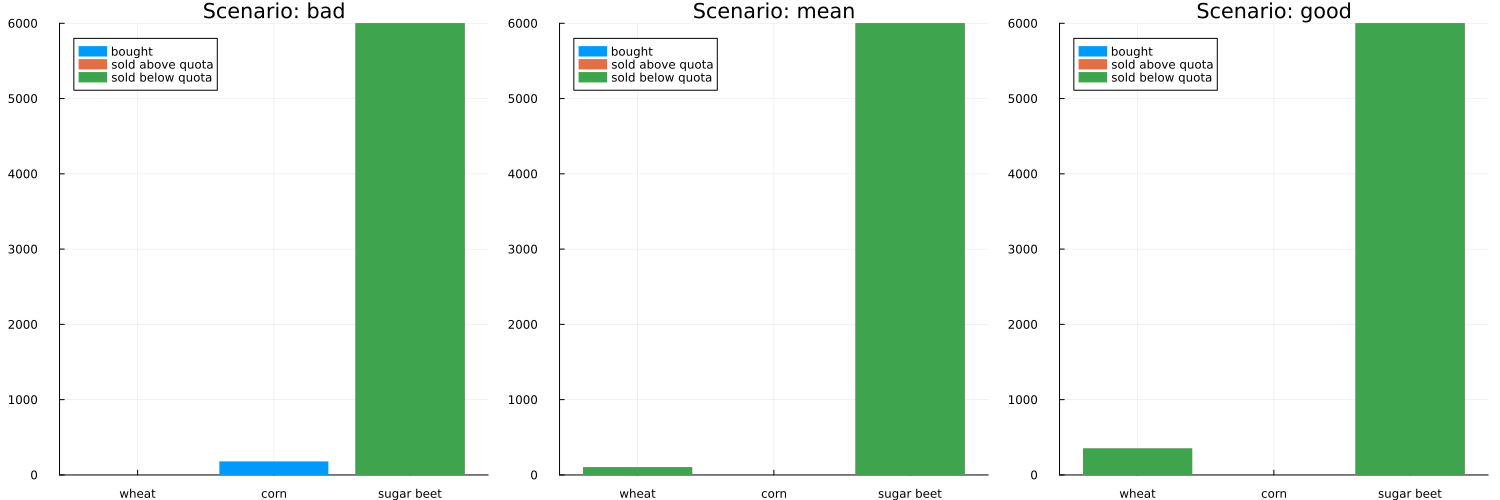

In [79]:
# Plot WS results
plot(plots...,layout = (1,3), size=(1500,500), link=:y,linecolor=false)